In [23]:
# Import relevant packages
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.python.framework.ops import disable_eager_execution
import matplotlib.pyplot as plt
import random

# Lubricate automatic differentiation
def get_gradient(x, fun):        
    with tf.GradientTape() as tape:
        tape.watch(x)          
        y = fun(x)

    g = tape.gradient(y, x)
    return g

# Initialize the neural network weights & biases
def initialize_NN(layers):        
    weights = []
    biases = []
    num_layers = len(layers) 
    for l in range(0,num_layers-1):
        W = xavier_init(size=[layers[l], layers[l+1]])
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)
        biases.append(b)        
    return weights, biases
    
# Use Xavier initialization of weights    
def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]        
    xavier_stddev = np.sqrt(2/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

# Neural net 
def neural_net(x, weights, biases):
    num_layers = len(weights) + 1
    lb = 0
    ub = 4*np.pi
    
    H = tf.constant(2.0*(x - lb)/(ub - lb) - 1.0, dtype=tf.float32)
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.tanh(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y

# Returns u & its first derivative
def net_u(x, weights, biases):        
    u = neural_net(x, weights, biases)   
    int_fun = lambda y: neural_net(y, weights, biases)     
    u_x = get_gradient(x, int_fun) # automatic differentiation 
    return u, u_x

# Evaluates satisfaction of governing equation
def net_f(x, weights, biases):
    u, u_x = net_u(x, weights, biases)
    int_fun = lambda y: neural_net(y, weights, biases)
    int_fun2 = lambda y: get_gradient(y, int_fun)
    u_xx = get_gradient(x, int_fun2) 
    f = u_xx + u 
    return f

# Custom loss function that regularizes fit with governing equation satisfaction
def loss_function(u_obs, x_obs, x_f, weights, biases):
    u, _ = net_u(x_obs, weights, biases)
    f = net_f(x_f, weights, biases)

    loss = tf.reduce_mean(tf.square(u - u_obs)) + \
           tf.reduce_mean(tf.square(f))
    return loss


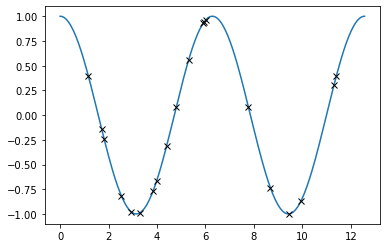

In [26]:
# Fabricate some data
x = np.linspace(0, 4*np.pi, 250)
u = np.cos(x) # exact solution to x'' + x = 0

# Randomly sample the data
N = 20
samples = random.sample(list(range(250)), N)
x_obs = tf.constant(x[samples], dtype=tf.float32, shape = [N,1])
u_obs = tf.constant(u[samples], dtype=tf.float32, shape = [N,1])

# Plot solution & observations
plt.plot(x, u)
plt.plot(x_obs, u_obs, 'kx')
plt.show()

In [39]:
# Define where we want to enforce physics
x_f = tf.constant(np.linspace(0, 4*np.pi, 50), dtype=tf.float32, shape=[50, 1])
lb = x[0]
ub = x[-1]

# Initialize the weights & biases
layers = [1, 50, 50, 1]
weights, biases = initialize_NN(layers)

# Train model
opt = keras.optimizers.Adam(learning_rate=0.01)
for j in range(2500):
    opt.minimize(lambda: loss_function(u_obs, x_obs, x_f, weights, biases), var_list=[weights, biases])        


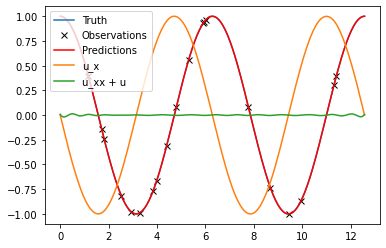

In [40]:
# Make prediction from trained model
u_pred, ux_pred = net_u(tf.constant(x, dtype=tf.float32, shape=[250,1]), weights, biases)
f_pred = net_f(tf.constant(x, dtype=tf.float32, shape=[250,1]), weights, biases)

# Show the prediction side-by-side
fig, ax = plt.subplots()
ax.plot(x, u, label='Truth')
ax.plot(x_obs, u_obs, 'kx', label='Observations')
ax.plot(x, u_pred, 'r', label='Predictions')
ax.plot(x, ux_pred, label='u_x')
ax.plot(x, f_pred, label='u_xx + u')
plt.legend()
plt.show()